## Robust Production - Inventory

The production inventory problem is one that addresses uncertainty in inventory management scenarios. The objective is to minimize the costs associated with inventory management while ensuring that customer demand is met consistently over a planning horizon. Since the demand is uncertain and varies within a specific bound, this problem can be classified as a robust optimization problem.

Taking the example introduced in Ben-Tal et al. (2004) [1], let us consider a single product inventory system which is comprised of a warehouse and $I$ factories. The planning horizon is $T$ periods. At period $t$:
- $d_t$ is the demand of the product that is uncertain
- $v_t$ is the amount of product in the warehouse at the beginning of a period
- $p_t$ is the amount of product to be produced during period $t$ by factory $i$ and is used to satisfy the demand of the period
- $P_t$ is the maximal production capacity of factory $i$ in time period $t$
- $c_t$ is the cost of producing a unit of product at factory $i$ in time period $t$
- $Q_t$ is the maximal cumulative production capacity of factory $i$ in time period $t$
- $V_{min}$ and $V_{max}$ are the minimal and maximal storage capacity of the warehouse, respectively
 
It is important to note that the upper and lower bounds of the problem had to be relaxed, with lesser perturbance to fit the solution within the Polyhedral uncertainty set.

With this information, the robust counterpart to the problem can be modeled into the following linear program:

$$
\begin{array}{ll}
\text{minimize} & F \\
\text{subject to} & c_t^Tp_t \leq F \\
                  & 0 \leq p_t \leq P_t \\
                  & 1^Tp_t \leq Q \\
                  & V_{min} \leq v_1 + 1^Tp_t - 1^Td_t \leq V_{max}
\end{array}
$$


To solve this problem, we will first import the required packages. 

In [1]:
import numpy as np 
import cvxpy as cp 
import lropt
import matplotlib.pyplot as plt

Next, we can consider $I$ = 3 factories producing a product in one warehouse. The time horizon $T$ is 24 periods. The  maximal production capacity of each one of the factories at each two-weeks period is $P(t) = 567$, and the integral production capacity of each one of the factories for a year is $Q = 13600$. The inventory at the warehouse should not be less then $300$ units, and cannot exceed $10000$ units. Initially, the inventory sits at $500$ units.

In [2]:
np.random.seed(1)
T = 24 #number of periods
I = 3 #number of factories
V_MIN = 300 # The lower and upper bounds must be relaxed for larger uncertainty, or the problem becomes infeasible
V_MAX = 10000
HALF = 0.5
SEASONAL_MULTIPLIER = 1000
INTEGRAL_CAPACITY = 13600
RHO = 1
V_INITIAL = 500
MAX_CAPACITY = 567
PROPORTIONS = [0.1, 0.2]
NUM_DEC = 3



The production cost for a factory $i$ at a period $t$ is given by:
$$
\begin{align*}
c(t) =  \alpha \left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad t  \in [1, 2, ... ,24] \\
\alpha \in [1, 1.5, 2]
\end{align*}
$$

In the robust optimization context, the demand is considered uncertain and seasonal, reaching its peak in winter. Specifically, the demand follows a seasonal pattern represented by:
$$
\begin{align*}
d^*(t) =  1000\left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad  t  \in [1, 2, ... ,24] \\
\end{align*}
$$

To handle this uncertainty, we adopt the Polyhedral uncertainty set. This uncertainty set is defined by:
$$
 \mathcal{U}_{\text{Polyhedral}} = \{Az+b \ | \ \|z \|_p \le \rho\}
$$
The following code defines these parameters for the problem.

In [3]:
def setup_parameters(proportion):
    P = np.full((I, T), MAX_CAPACITY)
    Q = [INTEGRAL_CAPACITY] * I
    alphas = np.array([1, 1.5, 2])
    c = [(alphas * (1 + HALF * np.sin(np.pi * (t - 1) / (T * HALF)))).flatten() for t in range(1, T + 1)]
    c = np.array(c).T
    
    t_values = np.arange(1, T + 1)
    d_star = SEASONAL_MULTIPLIER * (1 + HALF * np.sin(np.pi * (t_values - 1) / (T * HALF)))
    
    eye_matrix = np.eye(T)
    neg_eye_matrix = -np.eye(T)
    lhs = np.concatenate((eye_matrix, neg_eye_matrix), axis=0)
    
    rhs_upper = (1 + proportion) * d_star
    rhs_lower = (-1 + proportion) * d_star
    rhs = np.hstack((rhs_upper, rhs_lower))
    
    d = lropt.UncertainParameter(T, uncertainty_set=lropt.Polyhedral(lhs=lhs, rhs=rhs))
    
    return P, Q, c, d, rhs_upper, rhs_lower, d_star


Next, we will create a function to define the constraints of the function.

In [4]:
def define_constraints(P, Q, c, d):
    F = cp.Variable(nonneg=True)
    p = cp.Variable((I, T), nonneg=True)

    constraints = [
        cp.sum(cp.multiply(c, p)) <= F,
        p <= P,
        cp.sum(p, axis=1) <= Q
    ]
    
    for i in range(1, T + 1):
        mult = np.hstack([np.ones(i), np.zeros(T - i)])
        constraints.append(V_MIN <= cp.sum(cp.sum(cp.sum(p, axis=0)[:i])) - mult @ d + V_INITIAL)
        constraints.append(cp.sum(cp.sum(cp.sum(p, axis=0)[:i])) - mult @ d + V_INITIAL <= V_MAX)

    return F, p, constraints

This is a function that solves the problem and returns the optimal value.

In [5]:
def solve_problem(F, p, constraints):
    objective = cp.Minimize(F)
    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    return F.value, p.value

The following code calculates the robust optimal level of inventory over time. 

In [7]:
def calculate_inventory_levels(p, rhs_upper, d_star, rhs_lower):
    low_values = []
    mid_values = []
    high_values = []
    
    for i in range(1, T + 1):
        multvec = np.hstack([np.ones(i), np.zeros(T - i)])
        low = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ rhs_upper + V_INITIAL).value
        mid = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ d_star + V_INITIAL).value
        high = (cp.sum(cp.sum(p, 0)[:i]) - multvec @ (-rhs_lower) + V_INITIAL).value
        
        low_values.append(low)
        mid_values.append(mid)
        high_values.append(high)
    
    return low_values, mid_values, high_values

Finally, we can define a function to plot the inventory level over time for a given value of proportion. 

In [14]:
def plot_inventory_levels(ax, low_values, mid_values, high_values, PROPORTION):
    ax.plot(range(1, T + 1), low_values, label='Disturbance Lower Bound', color='blue', linestyle='--')
    ax.plot(range(1, T + 1), mid_values, label='Nominal Disturbance', color='green', linestyle='-')
    ax.plot(range(1, T + 1), high_values, label='Disturbance Upper Bound', color='red', linestyle='--')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Inventory Level')
    ax.set_title(f'Inventory Level Over Time\nPROPORTION = {PROPORTION}')
    ax.legend()
    ax.grid(True)


PROPORTION = 0.1: The robust optimal value is 38299.217
PROPORTION = 0.2: The robust optimal value is 43670.823


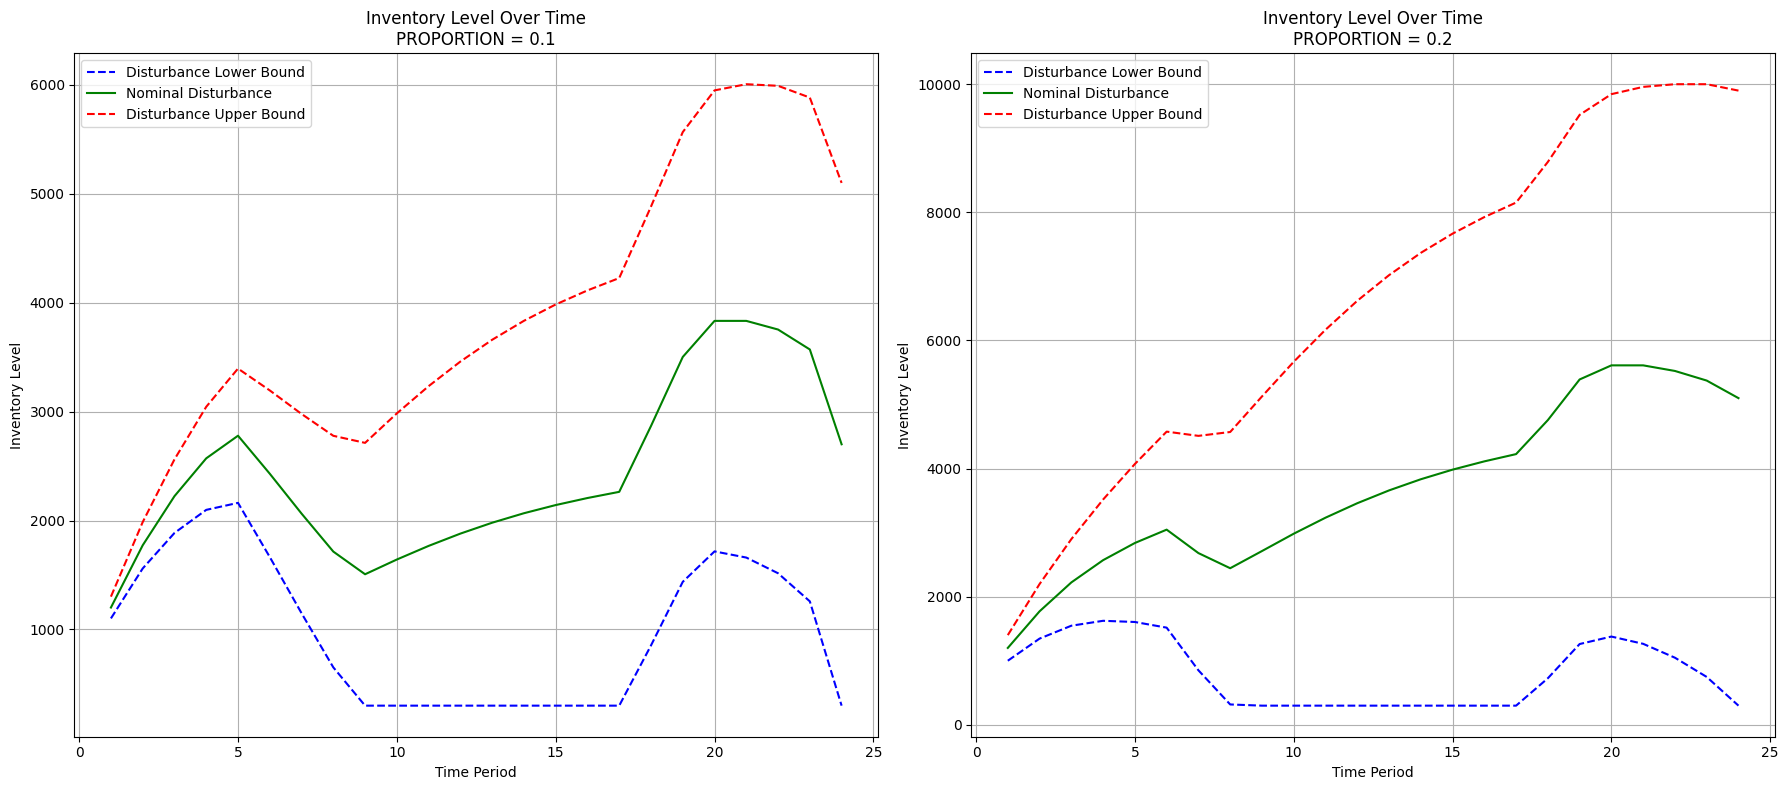

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8)) 

for i, PROPORTION in enumerate(PROPORTIONS):
    P, Q, c, d, rhs_upper, rhs_lower, d_star = setup_parameters(PROPORTION)
    F, p, constraints = define_constraints(P, Q, c, d)
    optimal_value, p_value = solve_problem(F, p, constraints)
        
    print(f"PROPORTION = {PROPORTION}: The robust optimal value is {round(optimal_value, NUM_DEC)}")
        
    low_values, mid_values, high_values = calculate_inventory_levels(p_value, rhs_upper, d_star, rhs_lower)
    plot_inventory_levels(axs[i], low_values, mid_values, high_values, PROPORTION)
    
plt.tight_layout()
plt.show()

## References

1. Ben-Tal, Aharon, Alexander Goryashko, Elana Guslitzer, and Arkadi Nemirovski. 2004. Adjustable robust solutions of uncertain linear programs. Mathematical Programming 99(2) 351-376. - add a clickable link